In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


In [3]:
# Define the stock symbol and date range
symbol = "SPY"
start_date = "2020-01-01"
end_date = "2023-12-31"

# Fetch data using yfinance
data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
def grid_trading_strategy(data, initial_capital=100000, grid_size=0.005, num_grids=20):
    close_prices = data['Close']
    
    # Calculate grid levels
    mid_price = float(close_prices.iloc[0])
    grid_levels = [mid_price * (1 + i * grid_size) for i in range(-num_grids, num_grids + 1)]
    
    # Initialize positions and performance tracking
    positions = pd.Series(index=close_prices.index, dtype=float)
    positions.iloc[0] = 0
    cash = initial_capital
    portfolio_value = pd.Series(index=close_prices.index, dtype=float)
    portfolio_value.iloc[0] = initial_capital
    
    transaction_cost = 0.0001  # 1 basis point
    
    for i in range(1, len(close_prices)):
        positions.iloc[i] = positions.iloc[i-1]
        prev_price = float(close_prices.iloc[i-1])
        curr_price = float(close_prices.iloc[i])
        
        for level in grid_levels:
            if prev_price < level <= curr_price:
                positions.iloc[i] -= 1  # Sell
                cash += level * (1 - transaction_cost)
            elif prev_price > level >= curr_price:
                positions.iloc[i] += 1  # Buy
                cash -= level * (1 + transaction_cost)
        
        portfolio_value.iloc[i] = positions.iloc[i] * curr_price + cash
    
    return positions, cash, portfolio_value

In [5]:
# Apply the strategy
initial_capital = 100000
positions, final_cash, portfolio_value = grid_trading_strategy(data, initial_capital=initial_capital)

/tmp/ipykernel_30457/1651570884.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mid_price = float(close_prices.iloc[0])
/tmp/ipykernel_30457/1651570884.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prev_price = float(close_prices.iloc[i-1])
/tmp/ipykernel_30457/1651570884.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  curr_price = float(close_prices.iloc[i])


In [6]:
# Calculate performance metrics
returns = portfolio_value.pct_change()
sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
max_drawdown = (portfolio_value / portfolio_value.cummax() - 1).min()
total_return = (portfolio_value.iloc[-1] - initial_capital) / initial_capital

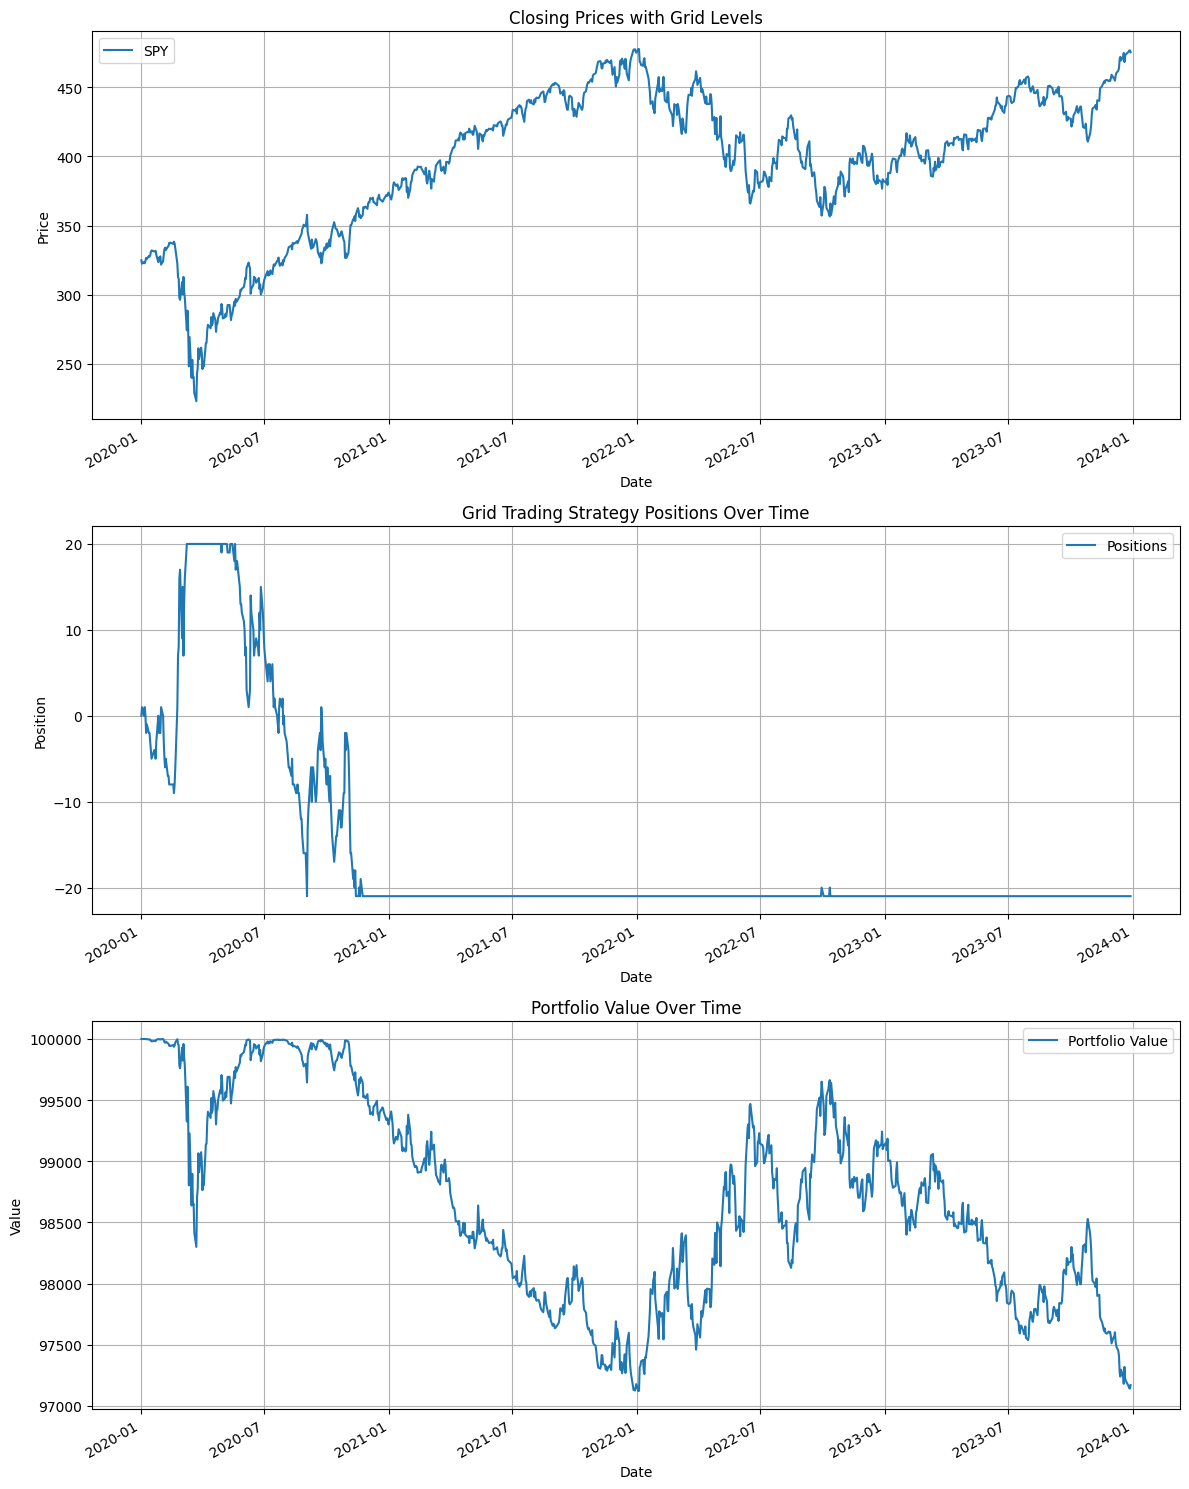

In [7]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))

# Plot 1: Closing Prices with Grid Levels
data['Close'].plot(ax=ax1, label='Closing Prices')
ax1.set_title('Closing Prices with Grid Levels')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend()

# Plot 2: Grid Trading Strategy Positions Over Time
positions.plot(ax=ax2, label='Positions')
ax2.set_title('Grid Trading Strategy Positions Over Time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Position')
ax2.grid(True)
ax2.legend()

# Plot 3: Portfolio Value Over Time
portfolio_value.plot(ax=ax3, label='Portfolio Value')
ax3.set_title('Portfolio Value Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Value')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

In [8]:
# Print performance metrics
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio Value: ${portfolio_value.iloc[-1]:,.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Final Cash: ${final_cash:,.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

# Interpretation
print("\nInterpretation:")
print("1. The closing prices of SPY show an overall upward trend from 2020 to 2023, with some volatility.")
print("2. The grid trading strategy's positions fluctuate between short and long positions, responding to price movements.")
print("3. The portfolio value shows a significant decline, especially in the latter half of 2023.")
print("4. The strategy appears to have underperformed, as evidenced by the negative total return and declining portfolio value.")
print("5. The large negative positions towards the end suggest the strategy may be taking on excessive risk.")
print("6. The strategy might benefit from additional risk management measures or parameter optimization.")

Initial Capital: $100,000.00
Final Portfolio Value: $97,170.13
Total Return: -2.83%
Final Cash: $107,151.64
Sharpe Ratio: -0.45
Maximum Drawdown: -2.88%

Interpretation:
1. The closing prices of SPY show an overall upward trend from 2020 to 2023, with some volatility.
2. The grid trading strategy's positions fluctuate between short and long positions, responding to price movements.
3. The portfolio value shows a significant decline, especially in the latter half of 2023.
4. The strategy appears to have underperformed, as evidenced by the negative total return and declining portfolio value.
5. The large negative positions towards the end suggest the strategy may be taking on excessive risk.
6. The strategy might benefit from additional risk management measures or parameter optimization.
